References or articles used for writing this notebook:

- https://stackoverflow.com/questions/26126442/combining-text-stemming-and-removal-of-punctuation-in-nltk-and-scikit-learn
- https://www.kaggle.com/madz2000/nlp-using-glove-embeddings-99-87-accuracy
- https://www.kaggle.com/iasnobmatsu/nlp-starter-guide-with-multiple-models#Modeling
- https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
- https://www.kaggle.com/nasirkhalid24/unsupervised-k-means-clustering-fake-news-87
- https://www.kaggle.com/muhammadshahzadkhan/is-it-real-news-nlp-lstm-acc-99-9#Now-we-need-to-apply-padding-to-make-sure-that-all-the-sequences-have-same-length.

### Import libraries needed, initial look at datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding
from keras.initializers import Constant
from keras.optimizers import Adam


from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords



In [2]:
fake=pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
real=pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Exploratory Data Analysis

The true dataset contains 21417 observations; the fake dataset contains 23481 observations

([<matplotlib.patches.Wedge at 0x7f685cf66fd0>,
 [Text(0.07936292514234608, 1.097133321940798, 'real news'),
  Text(-0.07936282242131068, -1.0971333293712864, 'fake news')])

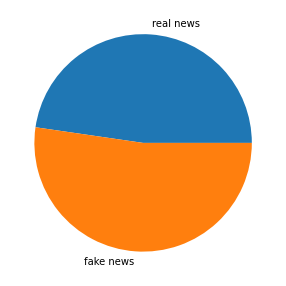

In [4]:
plt.figure(figsize=(5,5)) 
plt.pie([real.shape[0], fake.shape[0]],labels=['real news', 'fake news'], shadow=False)#pie chart

distribution of topics in fake/real news datasets

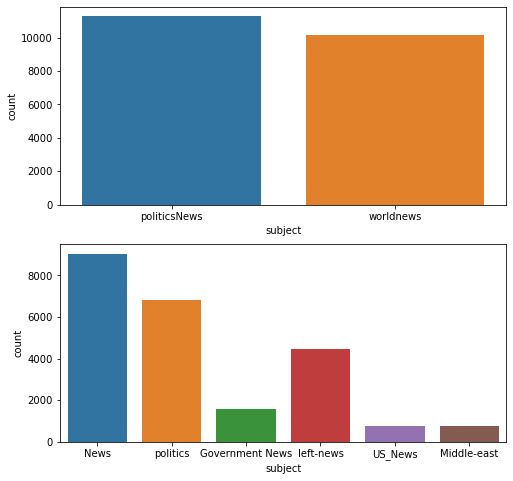

In [5]:
fig,a =  plt.subplots(2,1, figsize=(8,8)) 
sns.countplot(x='subject', data=real, ax=a[0])
sns.countplot(x='subject', data=fake, ax=a[1])

news text length distributions

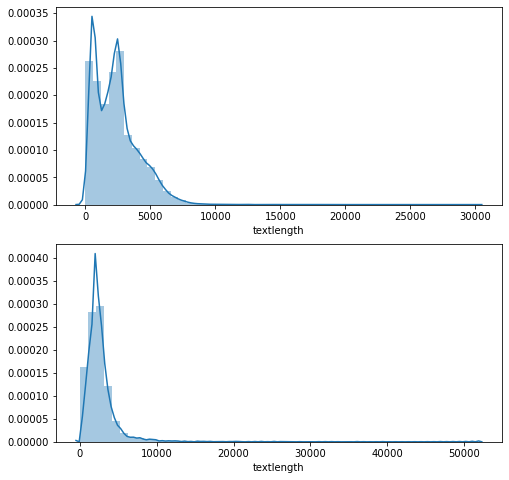

In [6]:
real['textlength']=real['text'].str.len()
fake['textlength']=fake['text'].str.len()


fig,a =  plt.subplots(2,1, figsize=(8,8)) 
sns.distplot(real['textlength'], ax=a[0])
sns.distplot(fake['textlength'], ax=a[1])

# real['textlength']

### Preprocessing

data cleaning

- remove tagging people (@kdhefjw)
- remove url
- remove things that are not exactly url but contain slash (pic.twitter.com/wiQSQNNzw0)
- remove (Rueters) which would indicate real news
- remove punctuations
- remove digits
- remove stop words
- stem words

In [7]:
# remove punctuation, stopwords

stemmer=PorterStemmer()
def clean(text):
    if "(Reuters)" in text: # real news contains this identifier sometimes
        text=text.split("(Reuters)")[1]
    text=re.sub(r'@[^s]*', '', text)
    text=re.sub(r'https?://\S+|www\.\S+', '', text)
    text=" ".join([wd for wd in text.split() if "\\" not in wd and "/" not in wd and wd not in stopwords.words('english')])
    text="".join([c for c in text if c not in string.punctuation])
    text="".join([c for c in text if not c.isdigit()])
    text=re.sub('[^a-zA-z\s]', '', text)
    text=text.lower()
    text=" ".join([stemmer.stem(wd) for wd in text.split()])
    return text


print(clean(fake["text"][3]))
fake["text"][3]

on christma day donald trump announc would back work follow day golf fourth day row the former realiti show star blast former presid barack obama play golf trump track outpac number golf game predecessor playedupd tracker trump appear trump properti round golf includ today s at pace pass obama firstterm total juli next year philip bump s washington post report discov trump websit realli weird everyth administr bizarr af the code contain refer obama golf unlik obama work fix problem golf cours howev code done correctlyth websit donald trump spent sever day row golf cours code serv follow messag event intern server error christoph ingraham snippet code appear page footer say paid rnc christoph ingraham s also as other note thread weird code clear would ever actual display know christoph ingraham s call out refer obama deletedupd the golf error messag remov trump gop websit they also fix javascript vs problem still clear messag would actual display sinc actual and presum page display diff

'On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH  Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf:  Unlike Obama, we are working to fix the problem   and not on the golf course.  However, the coding wasn t done correctly.The website of Donald Trump, who has spent several days in a row at the golf course, is coded to serve up the fo

cleaning data

In [8]:
real["isfake"]=0
fake["isfake"]=1

allnews=pd.concat([real, fake])

# takes about 2 hours to clean this dataset, use the already cleaned file instead of running this every time 
# allnews['text']=allnews['text'].apply(lambda text: clean(text))
# pd.DataFrame.to_csv(allnews, "cleaned_news_text.csv", index=False)


In [30]:
cleanedtext=pd.read_csv("/kaggle/input/cleaned-news/cleaned_news_text.csv")
print(cleanedtext['text'][1000])

print(cleanedtext['text'][40000])

presid bashar alassad famili role futur syria us secretari state rex tillerson said thursday ahead peac talk aim polit transit schedul resum next month tillerson said trump administr back geneva peac talk way end sixyearold war move polit transit elect he speak hold talk un special envoy syria staffan de mistura announc stall peac talk syrian govern stilltobeunit opposit would resum geneva nov the unit state want whole unifi syria role bashar alassad govern tillerson told report swiss citi end weeklong trip took saudi arabia qatar pakistan india it view i said mani time well believ futur assad regim assad famili the reign assad famili come end the issu brought about when trump administr came offic took view not prerequisit assad goe transit process start ad support russian air power iranback militia assad appear militarili unassail last month assad alli hezbollah declar victori syrian war those forc push islam state back larg swath eastern syria recent month past year taken numer pocke

In [31]:
X_train, X_test, y_train, y_test = train_test_split(cleanedtext.dropna()['text'],cleanedtext.dropna()['isfake'],test_size=0.1, random_state=10)#set random state


In [11]:
X_train.shape

(39764,)

In [12]:
X_test.shape

(4419,)

In [32]:

vtz=TfidfVectorizer()
X_train=vtz.fit_transform(X_train)
X_test=vtz.transform(X_test)

In [33]:
# print(vtz.get_feature_names()[:10])
# print(vec.toarray()[:10])
print(len(vtz.get_feature_names()))
print(X_train.shape)
print(X_test.shape)
print(cleanedtext.dropna().shape)



157664
(39764, 157664)
(4419, 157664)
(44183, 6)


### Models

Logistic regression

0.9805385833899072
[[2122   30]
 [  56 2211]]


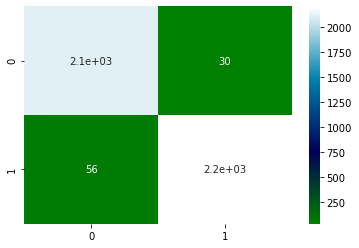

In [34]:
lr = LogisticRegression()
lr.fit(X_train, y_train) 
print(lr.score(X_test, y_test))
lr_pred=lr.predict(X_test)
lrcm=confusion_matrix(y_test,lr_pred)
print(lrcm)
sns.heatmap(lrcm, annot=True,cmap='ocean')

naive bayes

0.9332428151165422
[[2020  132]
 [ 163 2104]]


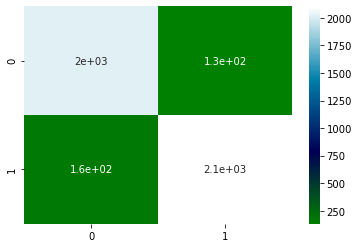

In [35]:

nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_pred=nb.predict(X_test)
print(nb.score(X_test, y_test))
nb_cm=confusion_matrix(y_test,nb_pred)
print(nb_cm)
sns.heatmap(nb_cm, annot=True,cmap='ocean')

LSTM

In [17]:
X_train, X_test, y_train, y_test = train_test_split(cleanedtext.dropna()['text'],cleanedtext.dropna()['isfake'],test_size=0.1, random_state=10)#set random state


In [18]:
tkn = Tokenizer()
tkn.fit_on_texts(X_train.values)
X_train = tkn.texts_to_sequences(X_train.values)
X_train = pad_sequences(X_train)
X_test = tkn.texts_to_sequences(X_test.values)
X_test = pad_sequences(X_test)



In [19]:
print(X_train.shape, y_train.shape)

(39764, 5022) (39764,)


In [22]:

from keras.layers import Bidirectional
model = Sequential()
# tf.keras.layers.Embedding(
#     input_dim,
#     output_dim,
#     input_length=None,
# )
model.add(Embedding(len(tkn.word_index) + 1, 256, input_length = X_train.shape[1]))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2)) #drop out to try avoid overfitting with too many hidden units
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1,activation='sigmoid')) # final layer activation is sigmoid becuase classifying 1/0
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())







Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5022, 256)         40368896  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 40,779,649
Trainable params: 40,779,649
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
model.fit(X_train, y_train, epochs=5, batch_size=128)

Epoch 1/5
311/311 [==============================] - 501s 2s/step - loss: 0.1203 - accuracy: 0.9524
Epoch 2/5
311/311 [==============================] - 497s 2s/step - loss: 0.0258 - accuracy: 0.9926
Epoch 3/5
311/311 [==============================] - 494s 2s/step - loss: 0.0168 - accuracy: 0.9956
Epoch 4/5
311/311 [==============================] - 496s 2s/step - loss: 0.0211 - accuracy: 0.9932
Epoch 5/5
311/311 [==============================] - 501s 2s/step - loss: 0.0085 - accuracy: 0.9974


In [25]:

score, acc = model.evaluate(X_test, y_test,batch_size=128)
print('accuracy:', acc)

35/35 [==============================] - 14s 390ms/step - loss: 0.0293 - accuracy: 0.9916
accuracy: 0.991627037525177


In [26]:
X=None
X_train=None
y_train=None
cleanedtext=None
pred=model.predict_classes(X_test)
print(pred[:20])

[[1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]]


[[2135   17]
 [  20 2247]]


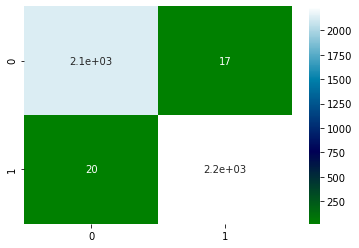

In [27]:
lstm_cm=confusion_matrix(y_test,pred)
print(lstm_cm)
sns.heatmap(lstm_cm,annot=True,cmap='ocean')
